<a href="https://colab.research.google.com/github/NicolaGabriele/MastodonContentCompliance/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
CONTEXT = "You are a decentralized social-network instance\'s moderator. Your role is to check if utent\'s post respects the instance rules. You must assign each post a score from 0 (if the post violate completely the instance\'s rules) to 10 (if the post respects all the instance\'s rules). Your response must be only the score number and anything else."
STRICT_CONTEXT = "You are a decentralized social-network instance\'s owner. Your role is to check if utent\'s post respects the instance rules. In order to classify posts you have to assign each post a score from 0(if the post violate completely the instance\'s rules) to 10(if the post respects all the instance\'s rules). You must be very strict in your evaluations. Please pay a lot of attention and let\'s think step by step. Your response must be only the score number and anything else."
SCORES_HOME = '/kaggle/input/instance-json/scores/scores'

In [46]:
def instance_mean_score(instance, instruction):
    l = []
    for rec in instance['records']:
        for test in rec['tests']:
              if test['instruction'] == instruction:
                    try:
                        l.append(int(test['score']))
                    except Exception:
                        continue
    return np.mean(l)

In [47]:
def total_mean_score(instruction):
    means = []
    for instance_filename in os.listdir(SCORES_HOME):
        try:
            means.append(instance_mean_score(json.load(open(os.path.join(SCORES_HOME, instance_filename), 'r')), instruction))
        except Exception:
            continue
    means = [x for x in means if not np.isnan(x)]
    return np.mean(means)

In [58]:
'''
distribuzione degli score cumulativa di tutte le istanze
'''
def plot_scores_distribution(instruction, title):
    l = []
    for instance_name in os.listdir(SCORES_HOME):
        try:
            instance = json.load(open(os.path.join(SCORES_HOME, instance_name), 'r'))
            for rec in instance['records']:
                for test in rec['tests']:
                    if test['instruction'] == instruction:
                        try:
                            l.append(int(test['score']))
                        except Exception:
                            continue
        except json.JSONDecodeError:
            continue
    plt.hist(l, bins = 11)
    plt.title(title)
    plt.xlabel('score')
    plt.ylabel('number of posts')
    plt.show()

In [5]:
'''
utile se vogliamo visualizzare la distribuzione degli score per ogni istanza
'''
def plot_instance_hist(instance, instruction, title):
  l = []
  for rec in instance['records']:
    for test in rec['tests']:
      if test['instruction'] == instruction:
        l.append(int(test['score']))
  plt.hist(l, bins = 11)
  plt.title(title)
  plt.xlabel('score')
  plt.ylabel('number of posts')
  plt.show()

In [63]:
def instance_std(instance, instruction):
    l = []
    for rec in instance['records']:
        for test in rec['tests']:
            if test['instruction'] == instruction:
                try:
                    l.append(int(test['score']))
                except Exception:
                    continue
    return np.std(l)

def mean_total_std(instruction):
    stds = []
    for instance_file in os.listdir(SCORES_HOME):
        try:
            instance = json.load(open(os.path.join(SCORES_HOME, instance_file), 'r'))
            stds.append(instance_std(instance, instruction))
        except Exception:
            continue
    stds = [x for x in stds if not np.isnan(x)]
    return np.mean(stds)


In [69]:
def get_instance_scores(instance):
    lazy = []
    strict = []
    for rec in instance['records']:
        try:
            test = rec['tests']
            if test[0]['instruction'] == CONTEXT:
                lazy.append(int(test[0]['score']))
            else:
                strict.append(int(test[0]['score']))
            if test[1]['instruction'] == CONTEXT:
                lazy.append(int(test[1]['score']))
            else:
                strict.append(int(test[1]['score']))
        except Exception:
            continue
        lazy = [x for x in lazy if not np.isnan(x)]
        strict = [x for x in strict if not np.isnan(x)] 
        if len(lazy) > len(strict):
            return lazy[:len(strict)], strict
        elif len(lazy) < len(strict):
            return lazy, strict[:len(lazy)]
        else:
            return lazy, strict

def get_total_scores():
    lazy_total = []
    strict_total = []
    for instance_name in os.listdir(SCORES_HOME):
        try:
            instance = json.load(open(os.path.join(SCORES_HOME, instance_name),'r'))
            lazy, strict = get_instance_scores(instance)
            lazy_total = lazy_total + lazy
            strict_total = strict_total + strict
        except Exception:
            continue
    return lazy_total, strict_total

def pearson():
    lazy, strict = get_total_scores()
    lazy_mean = np.mean(lazy)
    strict_mean = np.mean(strict)
    numerator = np.sum((lazy - lazy_mean) * (strict - strict_mean))
    std_lazy = np.std(lazy)
    std_strict = np.std(strict)
    denominator = std_lazy * std_strict * len(lazy)
    return numerator / denominator


In [75]:
import requests
from tqdm import tqdm
def plot_scores_vs_users(instruction, title):
    scores = []
    users = []
    for instance_name in tqdm(os.listdir(SCORES_HOME)):
        try:
            instance = json.load(open(os.path.join(SCORES_HOME, instance_name),'r'))
            x = instance_mean_score(instance, instruction)
            if not np.isnan(x):
                scores.append(x)
                users_url = f'http://{instance_name[:-12]}/api/v2/instance'
                users.append(requests.get(users_url).json()['usage']['users']['active_month'])
        except Exception:
            continue
    plt.scatter(users, scores)
    plt.title(title)
    plt.xlabel('number of users')
    plt.ylabel('mean score')
    plt.show()


score medio calcolato su tutte le istanze per il lazy context

In [48]:
print('{:.4f}'.format(total_mean_score(CONTEXT)))

7.7723


score medio calcolato su tutte le istanze per lo strict context

In [50]:
print('{:.4f}'.format(total_mean_score(STRICT_CONTEXT)))

6.0611


distribuzione degli score per il lazy context

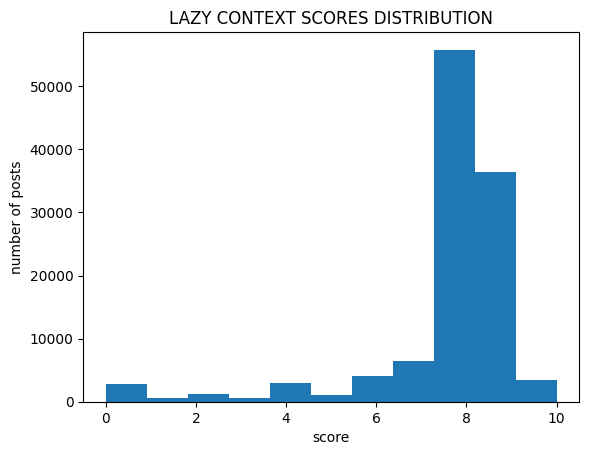

In [59]:
plot_scores_distribution(CONTEXT, 'LAZY CONTEXT SCORES DISTRIBUTION')

distribuzione degli score per lo strict context

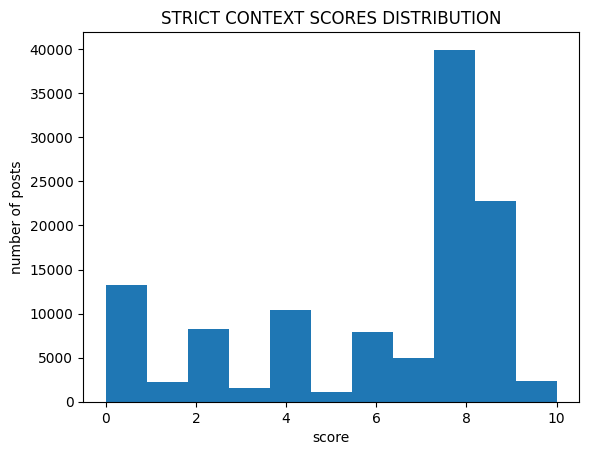

In [60]:
plot_scores_distribution(STRICT_CONTEXT, 'STRICT CONTEXT SCORES DISTRIBUTION')

deviazione standard media calcolata su tutte le istanze per il lazy context

In [65]:
print('{:.4f}'.format(mean_total_std(CONTEXT)))

1.2878


deviazione standard media calcolata su tutte le istanze per lo strict context

In [66]:
print('{:.4f}'.format(mean_total_std(STRICT_CONTEXT)))

2.3086


numero di utenti vs score medio nel caso di lazy context

In [ ]:
plot_scores_vs_users(CONTEXT,'lazy context users vs mean score')

  9%|▉         | 54/594 [00:56<11:29,  1.28s/it]

numero di utenti vs score medio nel caso di strict context

In [ ]:
plot_scores_vs_users(STRICT_CONTEXT,'strict context users vs mean score')

coefficiente di pearson

In [71]:
print('{:.4f}'.format(pearson()))

0.5531
